[Bag of Words](Bag-of-Words)

1. [Idea Behind Bag of Words](#Idea-Behind-Bag-of-Words)   
2. [An Aside on Documents](#An-Aside-on-Documents)    
3. [Applying Bag of Words to A Collection of Documents](#Applying-Bag-of-Words-to-A-Collection-of-Documents)    
4. [Word Frequency Vectors](Word-Frequency-Vectors)


# Bag of Words

We'll now put all that data cleaning to work to turn text data into mathematical objects. In particular we'll learn about three different types of vectors we can use to analyze text data, all built upon a concept known as bag of words.

##  Idea Behind Bag of Words
We've come close to bag of words when we looked at Harry Potter and the Prisoner of Azkaban and Harry Potter and the Goblet of Fire. It's more or less a fancy name for our word count dataframes.

The idea behind bag of words is that you take all of the words in your document and put them into a bag. Then you pull the words out and count them up.

As we've previously discussed this disregards ordering of words, but the same concept can be applied to -grams to create a bag of -grams model.

## An Aside on Documents
From now on we'll start referring to an observation (think row in a dataframe) of text data to a document. Colloquially the mention of a document may make you think of a single paper for a college or high school english class, but in the realm of NLP a document is more general. For example, an entire book may be a document, or perhaps just a single sentence or paragraph of the book. Other examples may include text messages, emails, tweets and vaccuum repair manuals.

## Applying Bag of Words to A Collection of Documents
So far we've made a bag of words vector for a single document, there is a slight difference when workinig with a collection of documents. Let's return to the excerpt from [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv)  `IMDB Dataset.csv`.   

I have reduced it into a smaller one called `Movie_Review.csv`

In [4]:
import pandas as pd
import numpy as np

# we'll use this for the spam messages
from nltk.tokenize import TweetTokenizer
from nltk import ngrams

In [7]:
#df = pd.read_csv('Movie_Review.csv')
df = pd.read_csv('Movie Review Data Set.csv')

In [8]:
df['sentiment'].value_counts()

positive    501
negative    499
Name: sentiment, dtype: int64

### Step 1 - Turn Negative/Positive into 0/1

Turn the label 'Negative' or 'Positive' into a 0 or a 1. Here 0 should mean the review was 'Negative', while a 1 should mean the review was 'Positive".

In [9]:
df.loc[df.sentiment == "positive",'coding'] = 1
df.loc[df.sentiment == "negative",'coding'] = 0

df_train = df.sample(frac=.8, random_state = 123).copy()
df_test = df.drop(df_train.index).copy()

In [10]:
df_train.shape

(800, 3)

In [11]:
df_test.shape

(200, 3)

In [12]:
df_test

,review,sentiment,coding
2,I thought this was a wonderful way to spend ti...,positive,1.0
3,Basically there's a family where a little boy ...,negative,0.0
8,Encouraged by the positive comments about this...,negative,0.0
14,This a fantastic movie of three prisoners who ...,positive,1.0
16,Some films just simply should not be remade. T...,positive,1.0
...,...,...,...
976,I had never heard of Larry Fessenden before bu...,negative,0.0
988,Stephane Audran is the eponymous heroine of th...,positive,1.0
990,It is incredible that there were two films wit...,negative,0.0
996,I hated it. I hate self-aware pretentious inan...,negative,0.0


In [13]:
df.head()

,review,sentiment,coding
0,One of the other reviewers has mentioned that ...,positive,1.0
1,A wonderful little production. <br /><br />The...,positive,1.0
2,I thought this was a wonderful way to spend ti...,positive,1.0
3,Basically there's a family where a little boy ...,negative,0.0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1.0


Now let's look into making a word count vector for the first two messages in the training set.

In [14]:
## define functions
# make the tokenizer object
tokenizer = TweetTokenizer()

# make word counts
def get_word_counts(tokens):
    word_dict = {}

    for word in tokens:
        if word in word_dict.keys():
            word_dict[word] = word_dict[word] + 1
        else:
            word_dict[word] = 1

    return pd.DataFrame({'word': word_dict.keys(),
                            'times_counted': word_dict.values()})

In [15]:
## get tokens
df_train['review_lower'] = df_train.review.str.lower()
df_train['tokens'] = df_train['review_lower'].apply(tokenizer.tokenize)

## get the first two reviews
rev_tokens_1 = list(df_train.tokens.values)[0]
rev_tokens_2 = list(df_train.tokens.values)[1]

print("message 1")
print(get_word_counts(rev_tokens_1))

print()
print()

print("message 2")
print(get_word_counts(rev_tokens_2))

message 1
        word  times_counted
0    luckily              1
1        for              1
2       bill              2
3     murray              7
4       this              5
..       ...            ...
245  feldman              1
246        8              1
247       10              1
248    stars              1
249    hound              1

[250 rows x 2 columns]


message 2
           word  times_counted
0             i              3
1    absolutely              1
2          love              1
3          this              3
4          film              1
5             .              6
6    everything              1
7         about              1
8            it              2
9        almost              1
10         felt              1
11         like              2
12     watching              1
13           me              1
14          and              3
15           my              1
16      friends              1
17           on              1
18       screen              

How would we compare these two vectors? They are two completely different dimensions and are not in vector spaces spanned by the same basis.

This is where the subtle difference comes into play. When making a bag of words vector model of the documents we first need to collect all of the unique words that occur accross all documents of the corpus (collection of documents). These unique words then correspond to a basis vector in the bag of words vector space.

Let's look at the first two messages bag of word vectors.



In [16]:
# This will take in a dataframe of "words" (note ngrams will work as well)
# and return a list of the unique words, which forms the basis
def get_bow_basis(df, column_name):
    basis_set = []

    for i in df.index:
        for word in df[column_name][i]:
            basis_set.append(word)

    return np.array(list(set(basis_set)))

## This will take in a basis set and a message's tokens
## and return the bow numpy array (vector)
def get_bow_vector(tokens, basis_set):
    vector = np.zeros(len(basis_set))

    for word in tokens:
        # Note this is here for when we look at the test set
        if word in basis_set:
            vector[basis_set == word] = vector[basis_set == word] + 1

    return vector

In [17]:
basis_set = get_bow_basis(df_train,'tokens')

In [18]:
basis_set

array(['tree', 'bloodiest', 'zucker', ..., 'granddad', 'dan', 'seaview'],
      dtype='<U60')

In [19]:
print("review 1", get_bow_vector(rev_tokens_1, basis_set))
print()
print("review 2", get_bow_vector(rev_tokens_2, basis_set))

review 1 [0. 0. 0. ... 0. 0. 0.]

review 2 [0. 0. 0. ... 0. 0. 0.]


### You Code
Make a np.array that records the bow vector for each of the documents in the training set. Each row of the array should represent a document, and each column one of the entries of the basis set. Note this sort of matrix is called a document-term matrix.

Call your array `doc_term_train`.

In [20]:
doc_term_train = np.zeros((len(df_train), len(basis_set)))

# looping through documents in training set
for i in range(len(df_train)):
  # row of the array is replaced with bow vector
  doc_term_train[i, :] = get_bow_vector(list(df_train.tokens)[i], basis_set)

In [ ]:
doc_term_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### More Coding By You
How many columns are there in your document-term matrix?
Answer: 17563

If you wanted to do a Sentiment identification process we'd probably want to reduce the dimensionality of this data set. Use `sklearn`'s PCA to produce an explained variance ratio curve following the code below.

In [ ]:
## Code here
np.shape(doc_term_train)

(800, 17563)

In [21]:
## import pca and matplotlib.pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

In [22]:
# This is a pipeline that scales the data and then
# applies pca
pca_pipe = Pipeline([('scale', StandardScaler()),
                         ('pca', PCA())])

# This fits the pipeline
pca_pipe.fit(doc_term_train)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA())])

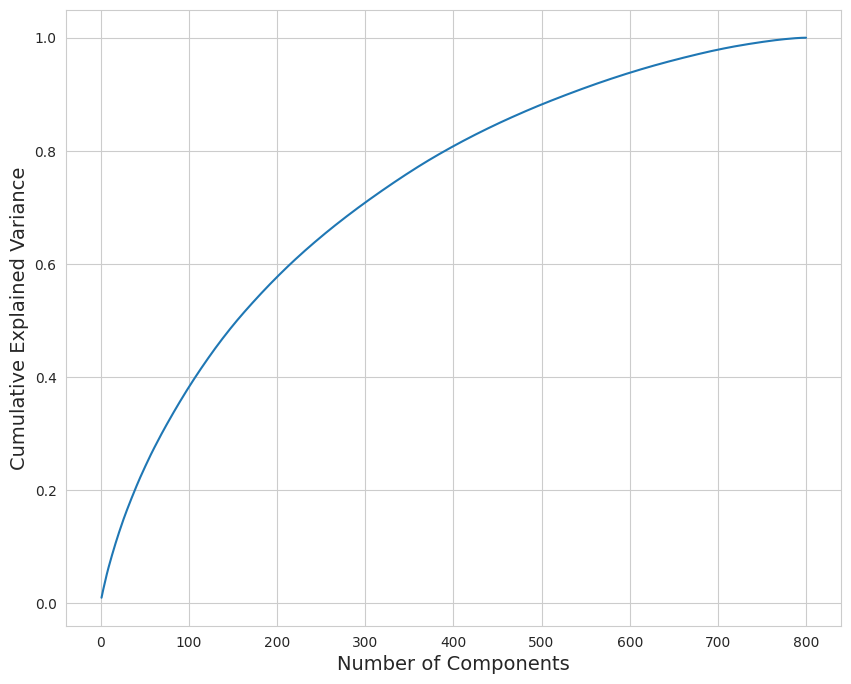

In [23]:
# make a figure
plt.figure(figsize=(10,8))

# plot the number of components on the x
# plot the explained variance ratio on the y
plt.plot(range(1, len(pca_pipe['pca'].explained_variance_ratio_) + 1),
            np.cumsum(pca_pipe['pca'].explained_variance_ratio_))

plt.xlabel("Number of Components", fontsize=14)
plt.ylabel("Cumulative Explained Variance", fontsize=14)

plt.show()

### Even More Coding By You
Let's use this PCA to build an `SVC` classifier.

__Note:__ that you don't need to know what the support vector classifier does to follow along with this code chunk. Just know that it is a very powerful classification algorithm, and you can always fill in the details later. After you've fit the classifier find the training true positive rate and the training false positive rate.

We'll use the first `1500` components of the PCA fit.

In [24]:
# This will give you the data projected onto
# the first 1500 PCA dimensions
fit = pca_pipe.transform(doc_term_train)[:, :1500]

In [25]:
# You define the functions to calculate True Positive Rate
# and False positive rate here
def tpr(actual, pred):
  # TPR = TP / (TP + FN)
  tp = np.sum((actual == 1) & (pred == 1))
  fn = np.sum((pred == 0) & (actual == 1))
  return tp / (tp + fn)

def fpr(actual, pred):
  # FPR = FP / (FP + TN)
  # FP = pred = 1 but actual is 0
  # TN = pred 0 and actual is 0
  fp = np.sum((actual == 0) & (pred == 1))
  tn = np.sum((pred == 0) & (pred == 0))
  return fp / (fp + tn)

In [26]:
# The Support Vector Classifier is stored
# in sklearn.svm
from sklearn.svm import SVC

In [27]:
# make a classifier object
svc = SVC()

In [28]:
# this fits the object on the training data
svc.fit(fit, df_train.coding.values)

# this produces the classifiers prediction on
# that data
pred = svc.predict(fit)

In [29]:
# print out the tpr and fpr here
print("Training tpr =", tpr(df_train.coding.values, pred))
print("Training fpr =", fpr(df_train.coding.values, pred))

Training tpr = 0.8897058823529411
Training fpr = 0.0


## Word Frequency Vectors
For a number of reasons that you may have already guessed (and potentially asked me about), bag of words vectors may not always be the best kind of vector for your application. A nice example from Natural Language Processing in Action is the following.

If I tell you that document A contains the word "dog" 3 times, and document B contains the word "dog" 100 times you may be inclinded to think that document B is more likely to be about dogs that document A. However, the sharp thinker (which I know all of you are!) would realize that the length of the documents is relavent here. In this example document A was a short email (30 words) about scheduling a vet appointment, while document B was the incredibly long novel War and Peace (580000 words). Thus dog is 1/10 of document A while dog is 0.00017 of document B.

This sort of example highlights the need for a term frequency vector. A term frequency vector takes the bag of words vector we previously discussed and divides each entry by the number of terms in the document. For example, if you had the following bag of words vector:

$$
(0,0,1,2,1)
$$
you'd end up with this frequency vector:
$$
(0,0,1/4,1/2,1/4)
$$

### You Code
Turn your document-term matrix from a bag of words matrix to a frequency matrix, call the matrix doc_term_train_freq.



In [34]:
doc_term_train_freq = np.divide(doc_term_train, len(doc_term_train))
doc_term_train_freq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### You Code Some More
Now run this data through PCA and plot the explained variance curve.

In [35]:
# we make a new pipeline for this second model
pca_pipe_freq = Pipeline([('scale',StandardScaler()),
                             ('pca',PCA())])

pca_pipe_freq.fit(doc_term_train_freq)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA())])

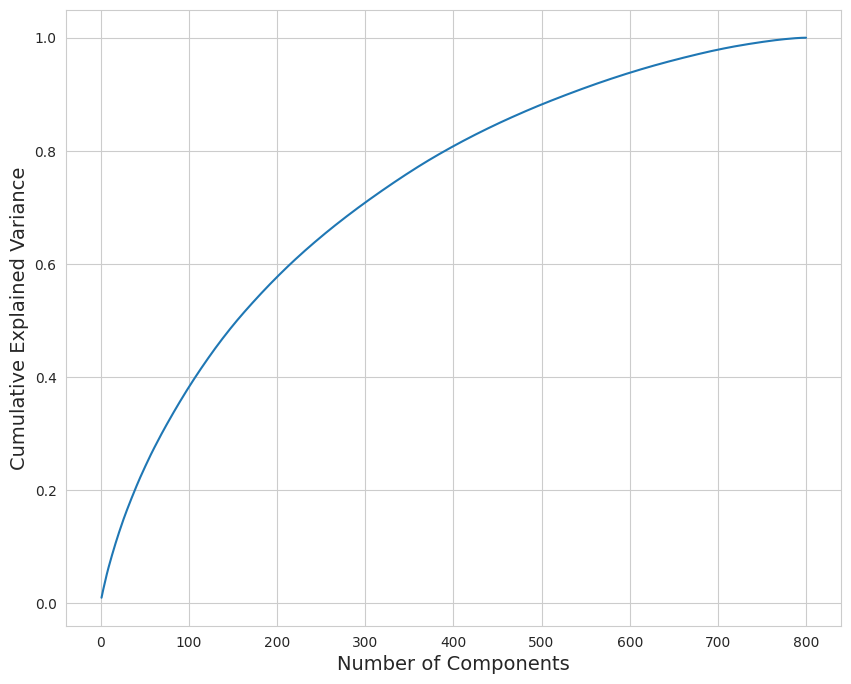

In [36]:
plt.figure(figsize=(10,8))


# Below we again plot the explained variance.
# note this plot should look identical to the previous one because
plt.plot(range(1, len(pca_pipe_freq['pca'].explained_variance_ratio_)+1),
            np.cumsum(pca_pipe_freq['pca'].explained_variance_ratio_))

plt.xlabel("Number of Components",fontsize=14)
plt.ylabel("Cumulative Explained Variance",fontsize=14)

plt.show()

### You Code Even More
Fit the classifier on the frequency matrix projected onto the first 1500 PCA dimensions, calculate the training tpr and fpr.

In [37]:
fit_freq = pca_pipe_freq.transform(doc_term_train_freq)[:,:1500]

In [38]:
svc_freq = SVC()

In [39]:
# this fits the object on the training data
svc_freq.fit(fit_freq, df_train.coding.values)

# this produces the classifiers prediction on
# that data
pred_freq = svc_freq.predict(fit_freq)

In [40]:
# You print out the training tpr and fpr here
print("Training tpr =", tpr(df_train.coding.values, pred_freq))
print("Training fpr =", fpr(df_train.coding.values, pred_freq))

Training tpr = 0.8897058823529411
Training fpr = 0.0


## The TLDR of TF-IDF (still probably a little long though!)
The final document vector type we'll discuss in this notebook is the TF-IDF vector. The TF of TF-IDF stands for term frequency, this is the vector type that we just finished working with. So let's introduce the IDF.

IDF stands for inverse document frequency. The document frequency of a given term is the number of documents that contain that term. For example if your corpus has 10 documents and 3 of them use the word "cat", then the document frequency for "cat" is 3/10. The inverse document frequency of "cat" in this example is the inverse of that, so 10/3.

To compute the tf-idf of a term for a given document you multiply the term frequency of the term within that document by the  (base 10) of the inverse document frequency for that term across the corpus.

Returning to our cat example. Let's suppose the word "cat" occurs 2 times in a document that has 12 words, and this document is a part of the 10 document corpus we mentioned a few seconds ago. Then the entry for "cat" in this document's tfidf vector is:

$$
\mbox{tfidf = term-frequency} \times \log (\mbox{inverse-document-frequency}) = \frac{2}{12}\log\left(\frac{10}{3}\right)
$$


I'm guessing you have two questions at this point.

### 1. Why the  $\log $?
I haven't found a satisfactory answer to this yet, but this stackexchange post https://math.stackexchange.com/questions/1362323/why-do-use-logarithms-in-the-tf-idf-formula gives a couple of explanations. One is related to Zipf's law (more on that in notebook 2). The other is that the tf-idf approach stems from the field of information theory and is related to something called entropy which involves the $\log $.

### 2. Why is this useful?
It's a reasonable question. Once reason this may be useful is because it kind of filters out common terms (What's the idf for a term that appears in every document?) and highlights terms that seldomly appear accross the corpus. This is useful for information retrieval from a corpus of documents all about the same thing. For instance if you have a a collection of documents about cats, and only one of them is about veterinary practices for cats the tf-idf vector for that document would give a heavy weight to terms like veterinarian.

### You Code Again
Compute the tf-idf matrix for our training data. Will this matrix be useful for classifation? I have no idea, but let's do it anyway. Call this matrix `doc_term_train_tfidf`.



In [ ]:
# To be honest this portion of the notebook is way too overwhelming for me to try and figure out with my current knowledge

### You Code More Again
Run the tf-idf matrix for the training data through PCA and plot the explained variance ratio.

In [ ]:
## Code here

In [ ]:
## Code here

### You Code Even More.. Again!
Now project the tfidf matrix onto the first 1500 dimensions and fit the svc.

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
# When you're ready print the training TPR and FPR here

### That's It!
That's it for this notebook, next up we're going to look at way we can calculate how alike two documents are. Note you can calculate the performance on the test set for homework below. Note to respect the train-test split the bag of words basis set should be the training bag of words basis set. Also when you calculate the tfidf use the idf calculated on the training set only.

### Calculate Test Set Performance Here

In [ ]:
## Code here


In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here

In [ ]:
## Code here